# Homework 5
by Jakub Wiśniewski

In [50]:
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import *
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

## Data 

In [6]:
df = pd.read_csv("../../clustering_R3.csv")
df = df.rename(columns={0: "X1", 1: "X2", 2: "X3"})
df

,X1,X2,X3
0,152.077986,197.910402,1.095707
1,145.520487,202.128032,2.738826
2,155.441273,198.122696,0.640457
3,150.389105,206.808383,0.686486
4,149.863221,205.417527,3.555814
...,...,...,...
995,327.058500,95.042417,5.819534
996,379.871471,118.620443,13.329955
997,386.363714,97.265599,8.635707
998,331.269212,100.623285,6.228514


In [16]:
fig = px.scatter_3d(df, x='X1', y='X2', z='X3', template = 'plotly_white')
fig.show()

We can clearly see 4 distinct clusters, 2 spherical and 2 being more stretched with X3 axis. There might be more clusters on top of those long "blobs". This will be challenge for algorithms. 

### Normalising data


In [22]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(df.iloc[:,[0,1,2]])
df_std = pd.DataFrame(ss.transform(df.iloc[:,[0,1,2]]), columns=["X1", "X2", "X3"])

df_std.head()

,X1,X2,X3
0,-0.762807,1.024554,-0.909772
1,-0.819582,1.125110,-0.566853
2,-0.733687,1.029615,-1.004782
3,-0.777429,1.236698,-0.995176
4,-0.781982,1.203537,-0.396348


In [23]:
fig = px.scatter_3d(df_std, x='X1', y='X2', z='X3', template = 'plotly_white')
fig.show()

This task seems like perfect job for `DBSCAN`. We will compare it with `spectral clustering`.

## Methodology

We will be evaluating methods with this metrics: 

In [209]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


* **The silhouette value** is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. [wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering))

* **Calinski Harabasz Score** It is also known as the Variance Ratio Criterion. The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)

* **Davies Bouldin Score** The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score. The minimum score is zero, with lower values indicating better clustering. [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html)


And we will try this algorithms: 
* `DBSCAN` - automatic number of clusters
* `Spectral Clustering` - number of clusters as parameter


For each algorithm I will make simple grid search for 2 parameters.


Function for visualization of results: 

In [57]:
def plot_3d(df, labels) : 
    """
    function plots scatterplot in 3D and colors it according to labels.
    
    df : pd.DataFrame
        dataframe to plot with columns [X1, X2, X3]
    
    labels : nupmy.ndarray
        numpy ndarray containing the labels as results of clustering.
    
    """
    
    X = copy.copy(df_std)
    X['label'] =  labels.astype('str')
    fig = px.scatter_3d(X, x='X1', y='X2', z='X3', template = 'plotly_white', labels = 'label', color = 'label')
    fig.show()
    
    return

## Experiment 
For each algorithm I will look at every possible combination of 2 parameters and measuring score with 3 metrics. I will specify number of clusters in `SpectralClustering` but not in `DBSCAN` because it should adjust it automatically. 

In [160]:
results = pd.DataFrame(columns= ["k","param1", "param2", "name","ss","chs","dbs"])

DBSCAN__eps         = [0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8]
DBSCAN__min_samples = [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]


for ep in DBSCAN__eps : 
    for msample in DBSCAN__min_samples : 
        dbsc = DBSCAN(ep, msample)
        dbsc.fit(df_std)
        
        k = len(np.unique(dbsc.labels_))
        
        if k > 1 : 
            ss   = silhouette_score(df_std, dbsc.labels_)
            chs  = calinski_harabasz_score(df_std, dbsc.labels_)
            dbs  = davies_bouldin_score(df_std, dbsc.labels_)

            row = {"k" : [k] ,"name" : ["DBSCAN"], "param1" : [ep], "param2" : [msample], "ss" : [ss], "chs" : [chs], "dbs" : [dbs]}
            row = pd.DataFrame(data = row)

            results = pd.concat([results, row])
        
        

In [119]:
results2 = pd.DataFrame(columns= ["k","param1", "param2", "name","ss","chs","dbs"])

SC__k = [2,3,4,5,6,7,8,9]
SC__n_init = [5,7,10,15,20,25]
SC__n_neighbors = [5,7,10,12,15,20,25]

for k in SC__k : 
    for ninit in SC__n_init :
        for nneighbors in SC__n_neighbors : 
            sc = SpectralClustering(n_clusters= k, n_init = ninit, n_neighbors= nneighbors , random_state= 13)
            sc.fit(df_std)
            
            ss   = silhouette_score(df_std, sc.labels_)
            chs  = calinski_harabasz_score(df_std, sc.labels_)
            dbs  = davies_bouldin_score(df_std, sc.labels_)

            row = {"k"      : [k], 
                   "name"   : ["SpectralClustering"],
                   "param1" : [ninit],
                   "param2" : [nneighbors],
                   "ss"     : [ss],
                   "chs"    : [chs],
                   "dbs"    : [dbs]}
            
            row = pd.DataFrame(data = row)

            results2 = pd.concat([results2, row])
 

In [161]:
res = pd.concat([results, results2])

In [202]:
res = res.sort_values(by = "k")
res

,k,param1,param2,name,ss,chs,dbs
0,2,7,20,SpectralClustering,0.662080,2482.032754,0.528374
0,2,25,25,SpectralClustering,0.662080,2482.032754,0.528374
0,2,25,20,SpectralClustering,0.662080,2482.032754,0.528374
0,2,25,15,SpectralClustering,0.662080,2482.032754,0.528374
0,2,25,12,SpectralClustering,0.662080,2482.032754,0.528374
...,...,...,...,...,...,...,...
0,10,0.6,4,DBSCAN,0.683727,1631.126922,0.665049
0,10,0.7,4,DBSCAN,0.685171,1670.599110,0.500668
0,14,0.2,9,DBSCAN,0.426981,425.952746,1.778492
0,22,0.1,4,DBSCAN,0.131599,124.659911,1.289043


## Visualization of results: 

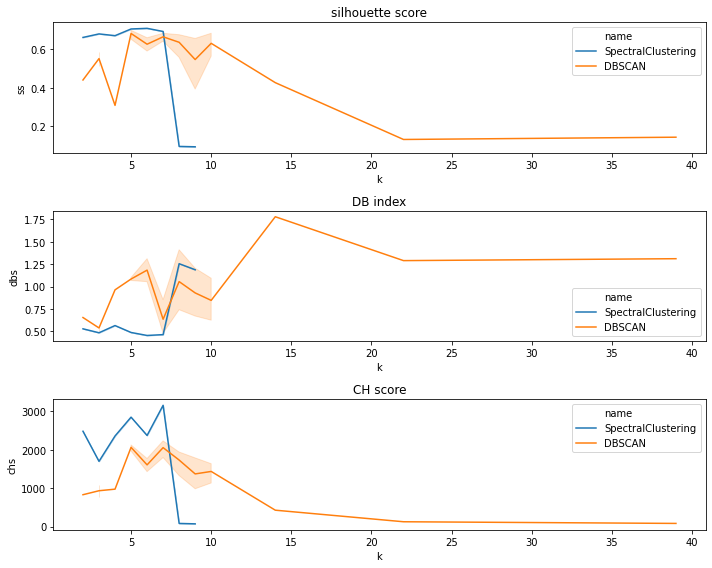

In [165]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,8))

sns.lineplot(x = "k", y = "ss" , hue = "name", data = res, ax = ax1).set_title("silhouette score")
sns.lineplot(x = "k", y = "chs", hue = "name", data = res, ax = ax3).set_title("CH score")
sns.lineplot(x = "k", y = "dbs", hue = "name", data = res, ax = ax2).set_title("DB index")

plt.tight_layout()

In all of this metrics Spectral clustering seems to be superior than DBSCAN. Judging by both metrics optimal number of neighbors should be 7.

Two parameters where specified not by accident, we will visualise how this parameters affected scores. 

### Analysis of parameters

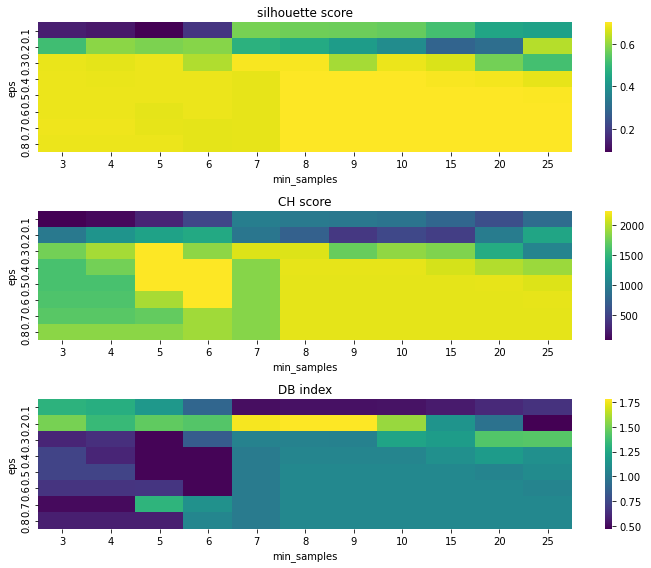

In [205]:
db_df = res.loc[res.name == "DBSCAN",:]

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,8))

h1 = db_df.pivot("param1", "param2", "ss")
sns.heatmap(h1, cmap="viridis", ax = ax1).set_title("silhouette score")
ax1.set(xlabel='min_samples', ylabel='eps')

h2 = db_df.pivot("param1", "param2", "chs")
sns.heatmap(h2, cmap="viridis", ax = ax2).set_title("CH score")
ax2.set(xlabel='min_samples', ylabel='eps')

h3 = db_df.pivot("param1", "param2", "dbs" )
sns.heatmap(h3, cmap="viridis", ax = ax3).set_title("DB index")
ax3.set(xlabel='min_samples', ylabel='eps')

plt.tight_layout()

Best parameters for DBSCAN are around 0.5-0.3 `eps` and 5-6 `samples`

With `SpectralClustering` algorithm I will look at `k = 7`

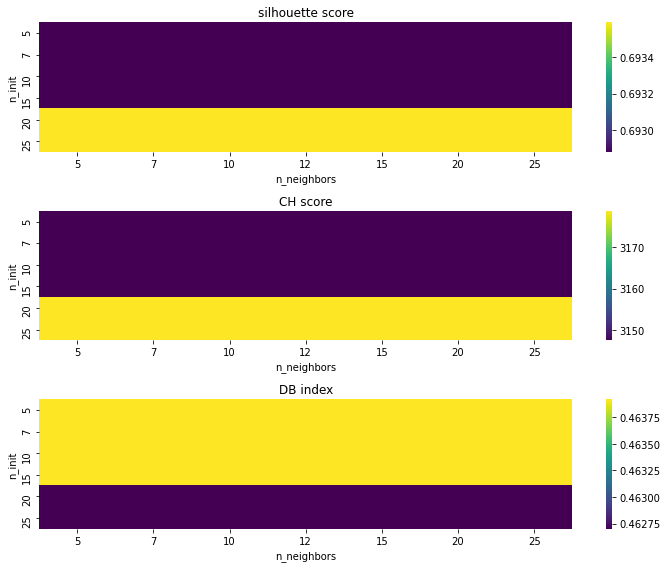

In [206]:
db_df = res.loc[res.name == "SpectralClustering",:]
db_df = db_df.loc[db_df.k == 7,:]


fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,8))

h1 = db_df.pivot("param1", "param2", "ss")
sns.heatmap(h1, cmap="viridis", ax = ax1).set_title("silhouette score")
ax1.set(xlabel='n_neighbors', ylabel='n_init')

h2 = db_df.pivot("param1", "param2", "chs")
sns.heatmap(h2, cmap="viridis", ax = ax2).set_title("CH score")
ax2.set(xlabel='n_neighbors', ylabel='n_init')

h3 = db_df.pivot("param1", "param2", "dbs" )
sns.heatmap(h3, cmap="viridis", ax = ax3).set_title("DB index")
ax3.set(xlabel='n_neighbors', ylabel='n_init')


plt.tight_layout()

In this case parameters don't seem to have big effect on scores (especially param2) . The best ones are 17-25 and all param2.

### Results and visualization
Metrics are consistent with each other. Scores in metrics with given parameters and number `k` reach maximum to the same parameters and `k`. Let's see how well our models cluster metrics. 

In [207]:
dbsc = DBSCAN(eps = 0.4, min_samples=6)
dbsc.fit(df_std)

plot_3d(df_std, dbsc.labels_)

`DBSCAN` assigned -1 to "noisy samples" and "cut" the top of those high clusters. Apart of that it did preety good job. 

In [208]:
sp = SpectralClustering(n_clusters= 7, n_init= 20, n_neighbors = 12)
sp.fit(df_std)

plot_3d(df_std, sp.labels_)

`SpectralClustering` did similar job but for `k=7` was better in every metric. 

In all 3 metrics for `k = 7` `SpectralClustering` was better than its opponent. So in this experiment it wins. 

# Oświadczenie

Oświadczam, że niniejsza praca stanowiąca podstawę do uznania osiągnięcia efektów uczenia się z przedmiotu "Wstęp do Uczenia Maszynowego" została wykonana przeze mnie samodzielnie.

~Jakub Wiśniewski 298850